<a href="https://colab.research.google.com/github/kkrusere/youTube-comments-Analyzer/blob/main/LLM_fine-tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **LLM-Powered Sentiment Analysis Pipeline** 

1. Introduction and Overview

    **What is Sentiment Analysis?**

    >> Sentiment analysis, also known as opinion mining, is a field of natural language processing (NLP) that focuses on determining the emotional tone or attitude expressed within a piece of text. It aims to categorize text as positive, negative, or neutral, and sometimes even delve into more nuanced emotions like joy, anger, or sadness.

    > * **Why Does Sentiment Analysis Matter?**

    > Sentiment Analysis can play a pivotal role in numerous applications, including (but not limited to):

    > 1. **Brand Monitoring:** Track customer opinions about products and services across social media and review platforms.
    > 2. **Market Research:** Gain insights into consumer sentiment towards brands, products, or trends.
    > 3. **Customer Service:** Analyze customer feedback to identify areas for improvement.
    > 4. **Social Media Analysis:** Monitor public sentiment towards events, news, or policies.
    > 5. **Financial Analysis:** Assess market sentiment to make informed investment decisions.

    **Limitation in Creating/developing, Training and Testing Sentiment Analysis models**

    >  > Creating, developing, training, and testing Sentiment Analysis (SA) models involves several limitations and challenges. Here are some of the key ones:
    > 1. Lack of Labeled Training Data
    > > * Limited Availability: Acquiring a large and diverse dataset with accurate sentiment labels can be difficult, especially for niche or specialized domains.
    > > * Cost and Time: Annotating data manually is time-consuming and expensive. Crowd-sourcing can introduce noise and inconsistency.
    > > * Quality of Annotations: The subjectivity of sentiment can lead to inconsistent labels even among human annotators.
    > 2. Complexity of Human Emotions
    > > * Subtlety and Nuance: Human emotions are complex and nuanced. Simple positive, negative, and neutral labels often fail to capture the full spectrum of sentiments.
    > > * Context-Dependence: The sentiment of a statement can depend heavily on the context, which might not be captured in the data.
    > 3. Ambiguity and Sarcasm
    > > * Ambiguity: Words and phrases can have different sentiments depending on the context. For example, "I saw this movie last night" could be positive or negative based on the speaker's tone and further context.
    > > * Sarcasm and Irony: Detecting sarcasm and irony is particularly challenging for SA models, as they often rely on cultural and contextual clues beyond the text itself.
    > 4. Language and Cultural Differences
    > > * Multilingual Challenges: Developing models that work across multiple languages requires extensive resources. Each language might require a separate model or significant adjustments to handle linguistic nuances.
    > > * Cultural Differences: Sentiments expressed in different cultures can vary widely, making it hard to generalize models across different demographics.
    > 5. Domain-Specific Challenges
    > > * Generalization: Models trained on generic datasets may not perform well in specialized domains such as medical or legal texts. Domain-specific models require specialized training data, which is often scarce.
    > > * Jargon and Slang: Different domains use specific jargon and slang that might not be well-represented in general sentiment datasets.
    > 6. Evolving Language
    > > * Language Change: Language and expressions evolve over time, and models need regular updates to stay relevant. New slang, trends, and shifts in meaning can quickly make a model outdated.
    > 7. Technical Challenges
    > > * Feature Extraction: Identifying the right features that capture sentiment effectively is challenging. Simple keyword-based approaches may miss nuances, while more sophisticated methods like embeddings require substantial computational resources.
    > > * Model Complexity: Building models that are both accurate and efficient can be difficult. More complex models like deep neural networks offer better performance but require more data and computational power.
    > 8. Evaluation and Metrics
    > > * Evaluation Metrics: Standard metrics like accuracy, precision, recall, and F1-score may not fully capture the effectiveness of a sentiment analysis model, especially in imbalanced datasets.
    > > * Real-world Testing: Models may perform well on test datasets but struggle with real-world data due to noise, variations in text, and other unforeseen factors.

    >  > Addressing these challenges often requires a combination of advanced techniques, including the use of transfer learning, semi-supervised learning, and the integration of external knowledge sources to improve the robustness and accuracy of Sentiment Analysis models.

    **Enter Large Language Models (LLMs)**

    >> Large Language Models (LLMs) are sophisticated machine learning models that have been trained on massive amounts of text data. They possess a remarkable ability to understand and generate human-like language.  LLMs can be fine-tuned for specific tasks, such as sentiment analysis, allowing them to leverage their vast knowledge and linguistic capabilities to make accurate predictions about the emotional tone of text.

    Pretrained Large Language Models (LLMs) like GPT-3, BERT, and their successors have shown considerable promise in addressing many of the challenges in creating, developing, training, and testing Sentiment Analysis (SA) models. Here’s how they can help:

    > 1. Lack of Labeled Training Data
    >> Transfer Learning: LLMs are pretrained on vast amounts of data across diverse domains. Fine-tuning these models on a smaller, domain-specific dataset can significantly enhance performance without requiring extensive labeled data.
    >> Zero-shot and Few-shot Learning: LLMs can perform tasks with little to no specific task-related training data, allowing for sentiment analysis with minimal labeled examples.
    > 2. Complexity of Human Emotions
    >> Rich Representations: LLMs capture nuanced language representations, which helps in understanding the subtleties and complexities of human emotions beyond simple positive, negative, and neutral sentiments.
    >> Context-Awareness: These models consider the context within and around the text, leading to better handling of context-dependent sentiment.
    > 3. Ambiguity and Sarcasm
    >> Contextual Understanding: LLMs use context to disambiguate meanings and can better detect sarcasm and irony, thanks to their sophisticated language understanding capabilities.
    >> Contextual Embeddings: By generating context-specific embeddings, LLMs can differentiate between sentiments in ambiguous phrases more effectively.
    > 4. Language and Cultural Differences
    >> Multilingual Capabilities: Models like mBERT and XLM-R are pretrained on multiple languages, enabling sentiment analysis across different languages without needing separate models for each.
    >> Cultural Sensitivity: Pretrained LLMs can be fine-tuned on culturally specific data to better capture the nuances and sentiments of different cultural contexts.
    > 5. Domain-Specific Challenges
    >> Fine-Tuning: LLMs can be fine-tuned on domain-specific datasets, leveraging their general language understanding to quickly adapt to specialized domains.
    >> Domain Adaptation: Techniques such as continual learning allow LLMs to incorporate new domain-specific jargon and slang without forgetting previously learned information.
    > 6. Evolving Language
    >> Adaptability: Pretrained models can be periodically fine-tuned on recent data to stay updated with evolving language and trends.
    >> Dynamic Updates: Ongoing training or incremental updates ensure that LLMs remain relevant and effective as language evolves.

    > 7. Technical Challenges
    >> Feature Extraction: LLMs inherently generate rich features and embeddings, reducing the need for manual feature engineering.
    >> Efficiency Improvements: Although LLMs can be computationally intensive, optimizations like distillation and pruning can make them more efficient for deployment.


    By leveraging these capabilities, pretrained LLMs significantly mitigate many of the traditional challenges in sentiment analysis, leading to more robust, accurate, and contextually aware models.

This Jupyter Notebook embarks on an exploratory journey into the realm of sentiment analysis for social media comments. Leveraging the power of Large Language Models (LLMs), we will delve into various techniques to extract sentiment from unlabeled text data. The focus will be on exploring different approaches, assessing their strengths and weaknesses, and ultimately uncovering valuable insights hidden within the vast landscape of social media conversations.

Social media platforms are teeming with user-generated content, offering a treasure trove of opinions, emotions, and reactions. Understanding the sentiment behind these comments is crucial for businesses, marketers, researchers, and anyone interested in gauging public opinion. However, the sheer volume and unstructured nature of social media data present a challenge for traditional sentiment analysis methods.

This notebook harnesses the capabilities of LLMs, which excel at understanding and generating human-like language, to tackle this challenge head-on. We will investigate various strategies, from zero-shot and few-shot learning to fine-tuning pre-trained models, and evaluate their effectiveness in extracting sentiment from unlabeled social media comments.

In [1]:
from google.colab import drive
import os
import json
#mounting google drive
drive.mount('/content/drive')

########################################

#changing the working directory
os.chdir("/content/drive/MyDrive/EV NLP Data")

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EV NLP Data


In [2]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !kaggle datasets download -d widhiwinata/twitter-and-reddit-sentiment-analysis
# !unzip twitter-and-reddit-sentiment-analysis.zip
# !rm twitter-and-reddit-sentiment-analysis.zip

In [3]:
!pip install nltk

We are going to do a semi supervised lable propergation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import string
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
sentimentdata = pd.read_csv("sentimentdataset.csv")
sentimentdata.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [6]:
sentimentdata = sentimentdata[['Text', 'Sentiment']]
sentimentdata.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,Positive
1,Traffic was terrible this morning. ...,Negative
2,Just finished an amazing workout! 💪 ...,Positive
3,Excited about the upcoming weekend getaway! ...,Positive
4,Trying out a new recipe for dinner tonight. ...,Neutral


In [7]:
# Cleaning-up
sentimentdata['Sentiment'] = sentimentdata['Sentiment'].str.strip()
sentimentdata['Sentiment'] = sentimentdata['Sentiment'].str.lower()


In [8]:
sentimentdata.shape

(732, 2)

In [9]:
sentimentdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       732 non-null    object
 1   Sentiment  732 non-null    object
dtypes: object(2)
memory usage: 11.6+ KB


In [10]:
sentimentdata.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,positive
1,Traffic was terrible this morning. ...,negative
2,Just finished an amazing workout! 💪 ...,positive
3,Excited about the upcoming weekend getaway! ...,positive
4,Trying out a new recipe for dinner tonight. ...,neutral


In [11]:
sentimentdata['Sentiment'].value_counts()

Sentiment
positive          45
joy               44
excitement        37
contentment       19
neutral           18
                  ..
lostlove           1
emotionalstorm     1
suffering          1
bittersweet        1
intrigue           1
Name: count, Length: 191, dtype: int64

In [12]:
def classify_sentiment(sentiment):
    positive_words = ['positive', 'happiness', 'joy', 'love', 'amusement', 'enjoyment', 'admiration', 'affection', 'awe', 'elation', 'euphoria', 'contentment', 'serenity', 'gratitude', 'hope', 'empowerment', 'compassion', 'tenderness', 'arousal', 'enthusiasm', 'fulfillment', 'reverence', 'playful', 'free-spirited', 'inspired', 'confident', 'zest', 'hopeful', 'proud', 'grateful', 'empathetic', 'compassionate', 'inspiration', 'motivation', 'satisfaction', 'blessed', 'optimism', 'enchantment', 'intrigue', 'playfuljoy', 'mindfulness', 'dreamchaser', 'whimsy', 'harmony', 'creativity', 'radiance', 'wonder', 'rejuvenation', 'adventure', 'awe', 'melodic', 'festivejoy', 'innerjourney', 'freedom', 'dazzle', 'harmony', 'artisticburst', 'radiance', 'wonder', 'inspiration', 'culinaryodyssey', 'curiosity', 'resilience', 'immersion', 'nostalgia', 'spark', 'gratitude', 'marvel', 'serenity', 'joy', 'happiness', 'enthusiasm', 'gratitude', 'positivity', 'kindness', 'friendship', 'love', 'success', 'thrill', 'reflection', 'enchantment', 'exploration', 'awe', 'amazement', 'romance', 'captivation', 'wonder', 'tranquility', 'grandeur', 'emotion', 'energy', 'celebration', 'charm', 'ecstasy', 'hope', 'creativity', 'colorful', 'pride', 'hypnotic', 'connection', 'iconic', 'euphoria', 'journey', 'engagement', 'touched', 'suspense', 'satisfaction', 'admiration', 'triumph', 'heartwarming', 'solace', 'breakthrough', 'joy in baking', 'imagination', 'vibrancy', 'mesmerizing', 'culinary adventure', 'winter magic', 'thrilling journey', 'nature\'s beauty', 'celestial wonder', 'creative inspiration', 'runway creativity', 'ocean\'s freedom', 'whispers of the past', 'positive', 'mischievous', 'happy']

    negative_words = ['negative', 'anger', 'fear', 'sadness', 'disgust', 'disappointed', 'despair', 'loneliness', 'jealousy', 'resentment', 'frustration', 'boredom', 'anxiety', 'intimidation', 'helplessness', 'envy', 'regret', 'bitter', 'confusion', 'overwhelmed', 'jealous', 'devastated', 'envious', 'dismissive', 'shame', 'elation', 'despair', 'grief', 'loneliness', 'frustration', 'anxiety', 'intimidation', 'helplessness', 'jealousy', 'curiosity', 'indifference', 'confusion', 'numbness', 'melancholy', 'nostalgia', 'ambivalence', 'acceptance', 'determination', 'numbness', 'bitterness', 'fearful', 'apprehensive', 'overwhelmed', 'jealous', 'devastated', 'frustrated', 'envious', 'dismissive', 'betrayal', 'suffering', 'emotionalstorm', 'isolation', 'disappointment', 'lostlove', 'melancholy', 'exhaustion', 'sorrow', 'darkness', 'desperation', 'ruins', 'desolation', 'regret', 'grief', 'heartbreak', 'betrayal', 'resilience', 'sorrow', 'loss', 'heartache', 'solitude', 'sad', 'hate', 'bad', 'disgust', 'embarrassed', 'mischievous']

    if sentiment in positive_words:
        return 'Positive'
    elif sentiment in negative_words:
        return 'Negative'
    else:
        return 'Neutral'



In [13]:
# We are using the `classify_sentiment` function to categorize the comment into 3 Positive, Negative and Neutral
sentimentdata['Sentiment'] = sentimentdata['Sentiment'].apply(classify_sentiment)

In [14]:
sentimentdata.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,Positive
1,Traffic was terrible this morning. ...,Negative
2,Just finished an amazing workout! 💪 ...,Positive
3,Excited about the upcoming weekend getaway! ...,Positive
4,Trying out a new recipe for dinner tonight. ...,Neutral


In [15]:
sentimentdata['Sentiment'].value_counts()

Sentiment
Positive    415
Negative    218
Neutral      99
Name: count, dtype: int64

In [16]:
class CustomLabelEncoder:
    """Custom label encoder for encoding and decoding labels."""

    def __init__(self):
        """
        Initialize the CustomLabelEncoder.

        Initializes the label mapping dictionaries.
        """
        self.label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
        self.reverse_label_map = {v: k for k, v in self.label_map.items()}

    def encode(self, labels):
        """
        Encode the given labels.

        Parameters:
        labels (list): List of labels to encode.

        Returns:
        list: Encoded labels.
        """
        encoded_labels = [self.label_map[label] for label in labels]
        return encoded_labels

    def decode(self, encoded_labels):
        """
        Decode the given encoded labels.

        Parameters:
        encoded_labels (list): List of encoded labels to decode.

        Returns:
        list: Decoded labels.
        """
        decoded_labels = [self.reverse_label_map[label] for label in encoded_labels]
        return decoded_labels


In [17]:
# Function to save comments data to a JSON file
def save_comments_to_json(comments, filename = 'youtube_comments.json'):
    with open(filename, 'w') as json_file:
        json.dump(comments, json_file, indent=4)

def load_comments_from_json(filename = 'youtube_comments.json'):
    with open(filename, 'r') as json_file:
        comments = json.load(json_file)
    return comments

In [18]:
comments_data = load_comments_from_json()
# Load the JSON data into a Pandas DataFrame
comments_data_df = pd.DataFrame(comments_data)

# Drop null values in the `comment_text ` column
comments_data_df = comments_data_df.dropna(subset=['comment_text'])
# Drop duplicates if there are any in the `comment_text ` column
comments_data_df = comments_data_df.drop_duplicates(subset='comment_text')


# Lowercase the text
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text'].str.lower()
# Remove punctuation
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# Remove stop words
stop_words = stopwords.words('english')
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


#reset dataframe index
comments_data_df.reset_index(inplace=True, drop=True)

comments_data_df.head()

,comment_text,like_count,reply_count,comment_text_cleaned
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,prices high dealerships keep adding dealership...
2,The government isn’t fast enough to patch poth...,89,6 replies,government isn’t fast enough patch potholes ro...
3,We have the coldest winters in many years here...,34,1 reply,coldest winters many years scandinavia places ...
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...


## **Modeling**

In [19]:
# Create a copy of the data
df = sentimentdata.copy()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [20]:
def preprocess_text(text):
    # Remove extra spaces and punctuation
    text = text.strip()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Removing stop words and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [21]:
df['Text'] = df['Text'].apply(preprocess_text)

# Feature extraction
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
def plot_confusion_matrix(y_true, y_pred):
  """
  This function creates and plots the confusion matrix for a given set of true and predicted labels.

  Args:
      y_true: A list containing the true labels.
      y_pred: A list containing the predicted labels.
  """
  # Generate the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Create a subplot for the confusion matrix
  ax = plt.subplot()

  # Plot the confusion matrix using seaborn
  sns.heatmap(cm, annot=True, ax=ax)  # Annotate cells with values

  # Set labels and title
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

  # Set tick labels for x and y axes
  ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
  ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

  # Display the plot
  plt.show()


### **Naive Bayes classifier**

Accuracy: 0.8027210884353742
Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.86        49
     Neutral       0.41      0.47      0.44        19
    Positive       0.86      0.86      0.86        79

    accuracy                           0.80       147
   macro avg       0.72      0.72      0.72       147
weighted avg       0.81      0.80      0.81       147



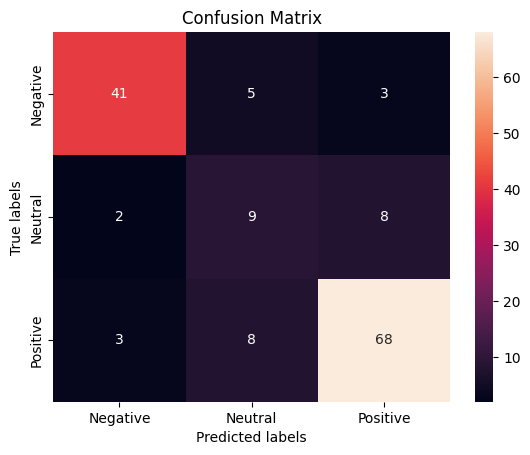

In [23]:
from sklearn.naive_bayes import MultinomialNB
# Training the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Model evaluation
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy_nb)
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

plot_confusion_matrix(y_test, y_pred_nb)


### **Logistic Regression**


Accuracy: 0.7959183673469388
Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.76      0.84        49
     Neutral       0.80      0.21      0.33        19
    Positive       0.74      0.96      0.84        79

    accuracy                           0.80       147
   macro avg       0.83      0.64      0.67       147
weighted avg       0.82      0.80      0.77       147



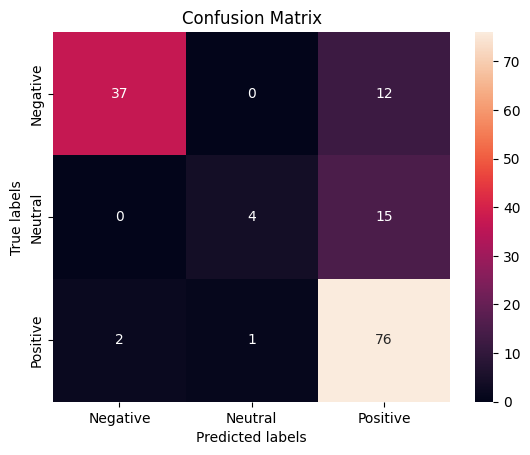

In [24]:
from sklearn.linear_model import LogisticRegression

# Training the Logistic Regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_lr = lr_classifier.predict(X_test)

# Model evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

plot_confusion_matrix(y_test, y_pred_lr)

### **Support Vector Machine**

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.41      0.57        49
     Neutral       0.00      0.00      0.00        19
    Positive       0.62      0.99      0.76        79

    accuracy                           0.67       147
   macro avg       0.52      0.47      0.44       147
weighted avg       0.65      0.67      0.60       147



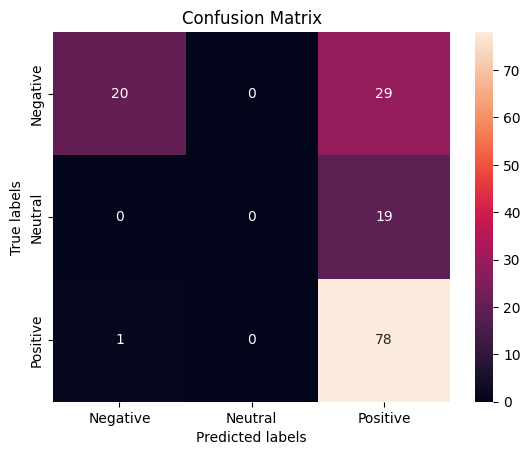

In [25]:
from sklearn.svm import SVC
# Training the Support Vector Machine classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Model evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

plot_confusion_matrix(y_test, y_pred_svm)

### **Random Forest Classifier**

Accuracy: 0.7210884353741497
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.51      0.68        49
     Neutral       1.00      0.11      0.19        19
    Positive       0.66      1.00      0.79        79

    accuracy                           0.72       147
   macro avg       0.89      0.54      0.55       147
weighted avg       0.82      0.72      0.68       147



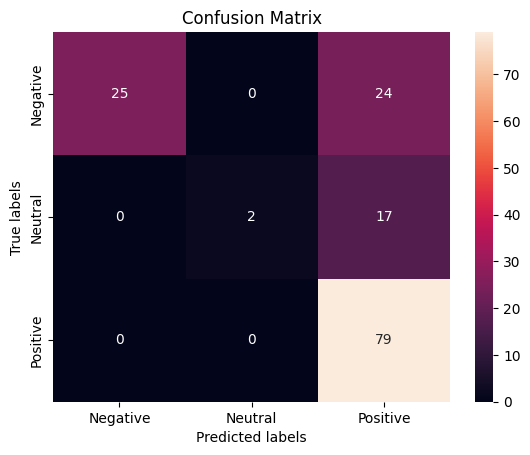

In [26]:
from sklearn.ensemble import RandomForestClassifier
# Training the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Model evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

plot_confusion_matrix(y_test, y_pred_rf)

### **Recurrent Neural Networks (RNNs)**

In [27]:
# Import the necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.preprocessing import LabelEncoder




Epoch 1/10
19/19 [==============================] - 3s 93ms/step - loss: 1.0497 - accuracy: 0.5692 - val_loss: 1.0128 - val_accuracy: 0.5374
Epoch 2/10
19/19 [==============================] - 2s 84ms/step - loss: 0.9859 - accuracy: 0.5744 - val_loss: 0.9584 - val_accuracy: 0.5374
Epoch 3/10
19/19 [==============================] - 2s 84ms/step - loss: 0.8790 - accuracy: 0.5744 - val_loss: 0.9140 - val_accuracy: 0.5374
Epoch 4/10
19/19 [==============================] - 2s 89ms/step - loss: 0.7020 - accuracy: 0.6000 - val_loss: 0.7697 - val_accuracy: 0.6395
Epoch 5/10
19/19 [==============================] - 2s 86ms/step - loss: 0.4909 - accuracy: 0.8530 - val_loss: 9881.5176 - val_accuracy: 0.3333
Epoch 6/10
19/19 [==============================] - 2s 91ms/step - loss: 649.7690 - accuracy: 0.8171 - val_loss: 0.7173 - val_accuracy: 0.7211
Epoch 7/10
19/19 [==============================] - 2s 84ms/step - loss: 652656.1875 - accuracy: 0.8393 - val_loss: 0.6075 - val_accuracy: 0.8027
Epo

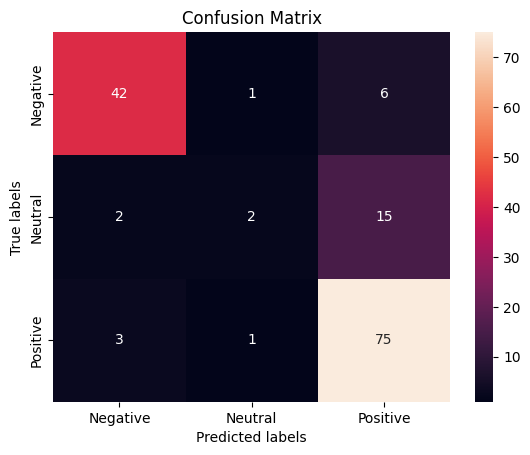

In [28]:
df['Text'] = df['Text'].apply(preprocess_text)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_len = 100  # Set the maximum sequence length
X_train_padded = pad_sequences(train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Initialize the custom label encoder
custom_encoder = CustomLabelEncoder()

# Encode the labels
y_train_encoded = np.array(custom_encoder.encode(y_train))
y_test_encoded = np.array(custom_encoder.encode(y_test))

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len))
rnn_model.add(LSTM(128, activation='relu'))
rnn_model.add(Dense(3, activation='softmax'))  # Three neurons for three classes, softmax activation
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use sparse_categorical_crossentropy for multi-class classification

# Train the model
rnn_model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_encoded))

# Evaluate the model
loss, accuracy = rnn_model.evaluate(X_test_padded, y_test_encoded)

y_pred_rnn = rnn_model.predict(X_test_padded)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)

accuracy_rnn = accuracy_score(y_test_encoded, y_pred_rnn)


print(f"\n\nAccuracy_1: {accuracy}  vs Accuracy_2: {accuracy_rnn}")

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rnn))

plot_confusion_matrix(y_test_encoded, y_pred_rnn)

### **Comparison of Models**

In [29]:
# Comparing the accuracy of different models
models = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest', 'RNN']
accuracies = [round(accuracy_nb, 3), round(accuracy_lr, 3), round(accuracy_svm, 3), round(accuracy_rf, 3), round(accuracy_rnn, 3)]

for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy}")

Naive Bayes: 0.803
Logistic Regression: 0.796
SVM: 0.667
Random Forest: 0.721
RNN: 0.81


In [30]:
# Preprocess the comments data
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(preprocess_text)

# Feature extraction
X = vectorizer.transform(comments_data_df['comment_text_cleaned'])

comments_data_df['nb_predictions'] = nb_classifier.predict(X)
comments_data_df['lr_predictions'] = lr_classifier.predict(X)
comments_data_df['svm_predictions'] = svm_classifier.predict(X)
comments_data_df['rf_predictions'] = rf_classifier.predict(X)


comments_data_df.head()

,comment_text,like_count,reply_count,comment_text_cleaned,nb_predictions,lr_predictions,svm_predictions,rf_predictions
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...,Negative,Positive,Positive,Positive
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,price high dealership keep adding dealership f...,Positive,Positive,Positive,Positive
2,The government isn’t fast enough to patch poth...,89,6 replies,government isnt fast enough patch pothole road...,Positive,Positive,Positive,Positive
3,We have the coldest winters in many years here...,34,1 reply,coldest winter many year scandinavia place nev...,Positive,Positive,Positive,Positive
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...,Positive,Positive,Positive,Positive


In [31]:
custom_encoder = CustomLabelEncoder()

y_pred_rnn_comments = rnn_model.predict(pad_sequences(tokenizer.texts_to_sequences(comments_data_df['comment_text_cleaned']), maxlen=max_len))
y_pred_rnn_comments = np.argmax(y_pred_rnn_comments, axis=1)
comments_data_df['rnn_predictions'] = custom_encoder.decode(y_pred_rnn_comments)

449/449 [==============================] - 12s 27ms/step


In [32]:
comments_data_df.head(10)

,comment_text,like_count,reply_count,comment_text_cleaned,nb_predictions,lr_predictions,svm_predictions,rf_predictions,rnn_predictions
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...,Negative,Positive,Positive,Positive,Negative
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,price high dealership keep adding dealership f...,Positive,Positive,Positive,Positive,Positive
2,The government isn’t fast enough to patch poth...,89,6 replies,government isnt fast enough patch pothole road...,Positive,Positive,Positive,Positive,Neutral
3,We have the coldest winters in many years here...,34,1 reply,coldest winter many year scandinavia place nev...,Positive,Positive,Positive,Positive,Positive
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...,Positive,Positive,Positive,Positive,Positive
5,A friend of mine pre ordered the lightning in ...,495,58 replies,friend mine pre ordered lightning canada 75k p...,Positive,Positive,Positive,Positive,Positive
6,I rented an EV. The biggest issue was anxiety ...,25,None,rented ev biggest issue anxiety range particul...,Negative,Negative,Positive,Negative,Negative
7,00:02EV sales are slowing despite significant ...,56,6 replies,0002ev sale slowing despite significant invest...,Negative,Negative,Positive,Neutral,Negative
8,I’m surprised there was no mention of Franchis...,618,36 replies,im surprised mention franchise dealership addi...,Negative,Positive,Positive,Negative,Negative
9,I don't think they ever directly mentioned tha...,492,36 replies,dont think ever directly mentioned lot people ...,Positive,Positive,Positive,Positive,Positive


In [33]:
fig = px.histogram(comments_data_df,
                 x=['nb_predictions','lr_predictions','svm_predictions','rf_predictions','rnn_predictions'],
                 title='Frequency Distribution of Sentiment Analysis Predictions')

fig.update_layout(
    xaxis_title='Prediction Type',
    yaxis_title='Frequency',
    title_font=dict(size=16),
    xaxis_tickangle=-45,
    yaxis=dict(tickfont=dict(size=12)),
    margin=dict(l=80, r=50, t=70, b=50)
)

fig.show()